In [151]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
#For the neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import os
import random

STEP 1 = LOADING, EDDITING, VISUALISING DATASET

In [152]:
#LOADING dataset
filename = 'BTC-USD.csv'
data = pd.read_csv(filename)

In [153]:
#EDITING DATASET
#check for null values
print(data.isnull().sum())
print("Dataframe's shape: ",data.shape)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Dataframe's shape:  (1827, 7)


In [154]:
# get number of unique values for each column
print(data.nunique())

Date         1827
Open         1826
High         1826
Low          1827
Close        1825
Adj Close    1825
Volume       1827
dtype: int64


In [155]:
#Visualising Dataset
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-20,792.247009,801.336975,791.497009,800.875977,800.875977,99629296
1,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
2,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
3,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
4,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008


In [156]:
count=0
for i in range(data.shape[0]):
  if(data['Adj Close'][i]==data['Close'][i]):
    count+=1
print(count)

1827


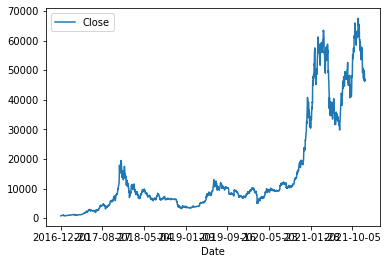

In [157]:
#as time series
data.plot.line(y="Close", x="Date")
plt.show()

In [158]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,15182.963836,15602.934020,14721.770709,15205.688536,15205.688536,2.090553e+10
std,16816.404465,17282.714832,16275.508579,16824.102298,16824.102298,2.123368e+10
min,775.177979,801.336975,755.755981,777.757019,777.757019,6.085170e+07
25%,5301.157471,5419.827637,5217.846680,5309.171875,5309.171875,4.450275e+09
50%,8573.980469,8743.500000,8296.218750,8586.473633,8586.473633,1.603826e+10
75%,13445.887207,13840.397461,12897.904297,13492.202637,13492.202637,3.260844e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


<AxesSubplot:ylabel='Density'>

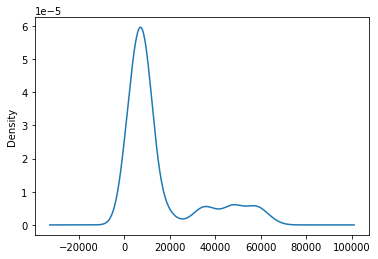

In [159]:
data['Open'].plot.kde()

<AxesSubplot:ylabel='Density'>

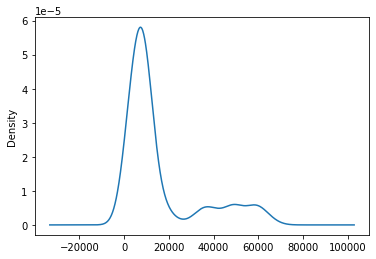

In [160]:
data['High'].plot.kde()

<AxesSubplot:ylabel='Density'>

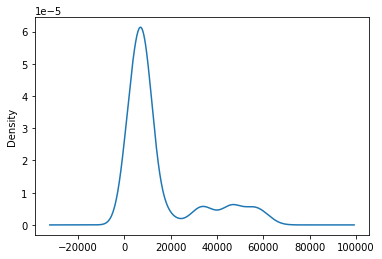

In [161]:
data['Low'].plot.kde()

<AxesSubplot:ylabel='Density'>

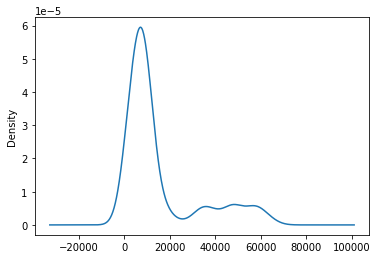

In [162]:
data['Close'].plot.kde()

<AxesSubplot:ylabel='Density'>

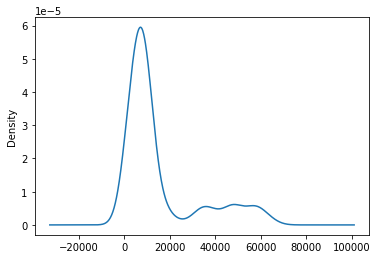

In [163]:
data['Adj Close'].plot.kde()

<AxesSubplot:ylabel='Density'>

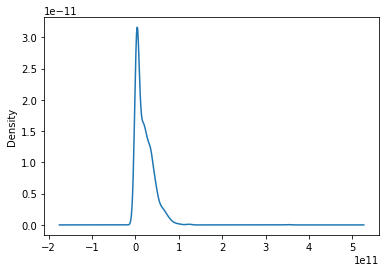

In [164]:
data['Volume'].plot.kde()

STEP 2 = CLOSING VALUES: PREPROCESSING-TRAINING-DIAGNOSTICS

In [165]:
#normalisation
scaler = MinMaxScaler()
#we dont need column "Date"
#we will also drop column "Adj Close, as it is the same as column "Close"
names =["Open", "High", "Low", "Volume", "Close"]
data = scaler.fit_transform(data[names])
data = pd.DataFrame(data, columns=names)
data.head()

,Open,High,Low,Volume,Close
0,0.000256,0.000000,0.000545,0.000111,0.000346
1,0.000381,0.000485,0.000665,0.000270,0.000846
2,0.000884,0.001095,0.001195,0.000397,0.001299
3,0.001343,0.001821,0.001660,0.000612,0.002159
4,0.002201,0.001797,0.001990,0.000219,0.001813


In [166]:
#keep close data in a separate DataFrame
data_close= data[["Close"]] #needed in order to preserve the actual close value per day
data_close= data_close.rename(columns = {'Close':'Actual_Close'})
#rolling over every two rows, check if the later close value is greater than the preceding one and return 1, otherwise 0
data_close["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
data_close.head()

,Actual_Close,Target
0,0.000346,NaN
1,0.000846,1.0
2,0.001299,1.0
3,0.002159,1.0
4,0.001813,0.0


In [167]:
#ensure that the prediction of future prices depends on past day's data
data_prev = data.copy()
data_prev = data_prev.shift(1)
data_prev.head()

,Open,High,Low,Volume,Close
0,NaN,NaN,NaN,NaN,NaN
1,0.000256,0.000000,0.000545,0.000111,0.000346
2,0.000381,0.000485,0.000665,0.000270,0.000846
3,0.000884,0.001095,0.001195,0.000397,0.001299
4,0.001343,0.001821,0.001660,0.000612,0.002159


In [168]:
#TRAINING
# Create training data
predictors = ["Volume", "Open", "High", "Low"]
data_close = data_close.join(data_prev[predictors]).iloc[1:]
X=data_close[predictors]
data_close.head()

,Actual_Close,Target,Volume,Open,High,Low
1,0.000846,1.0,0.000111,0.000256,0.000000,0.000545
2,0.001299,1.0,0.000270,0.000381,0.000485,0.000665
3,0.002159,1.0,0.000397,0.000884,0.001095,0.001195
4,0.001813,0.0,0.000612,0.001343,0.001821,0.001660
5,0.001773,0.0,0.000219,0.002201,0.001797,0.001990


# Logistic Regression Model

In [169]:
y=data_close['Target']
x_train,x_test,y_train,y_test=train_test_split(X,y,shuffle=False,test_size=0.2)

In [170]:
clf1 = LogisticRegression(random_state=0)
scores=np.array(cross_val_score(clf1, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.5404109589041095


In [171]:
clf2 = LogisticRegression(random_state=0,C=0.01,class_weight='balanced')
scores=np.array(cross_val_score(clf2, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.5273972602739726


In [172]:
clf3 = LogisticRegression(random_state=0,C=0.01,penalty='elasticnet',solver='saga',l1_ratio=0.0025)
scores=np.array(cross_val_score(clf3, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.5520547945205478


In [173]:
pred=clf3.fit(x_train, y_train).predict(x_test)

print("LOSS: ",log_loss(y_test, pred))
print("Accuracy: ", accuracy_score(y_test, pred))

LOSS:  16.609195012710366
Accuracy:  0.5191256830601093


# Linear Regression Model

In [174]:
y=np.array(data_close['Actual_Close'])
x_train,x_test,y_train,y_test=train_test_split(X,y,shuffle=False,test_size=0.3)

In [175]:
clf1 = LinearRegression()
scores=np.array(cross_val_score(clf1, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.9671587809066109


In [176]:
clf2 = LinearRegression(fit_intercept=False)
scores=np.array(cross_val_score(clf2, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.9680977740281584


In [177]:
clf3 = LinearRegression(positive=True)
scores=np.array(cross_val_score(clf3, x_train, y_train, cv=5))
c_v_score=np.mean(scores)
print(c_v_score)

0.9641499823720456


In [178]:
pred=clf2.fit(x_train, y_train).predict(x_test)
print("TEST RMSE:",mean_squared_error(y_test, pred,squared=False))
print("Accuracy: ", accuracy_score(y_test, pred))

TEST RMSE: 0.025770715541068027



# Neural Network Model

In [179]:
close_values=data_close['Actual_Close']
train,test=train_test_split(close_values,test_size=0.2)
train=np.array(train).reshape(train.shape[0],1)
test=np.array(test).reshape(test.shape[0],1)

In [180]:
xTrain=[]
yTrain=[]
for i in range(50,train.shape[0]):
  xTrain.append(train[i-50:i])
  yTrain.append(train[i])
xTrain,yTrain=np.array(xTrain),np.array(yTrain)

In [181]:
xTest=[]
yTest=[]
test=np.array(test)
for i in range(50,test.shape[0]):
  xTest.append(test[i-50:i])
  yTest.append(test[i])
xTest,yTest=np.array(xTest),np.array(yTest)

In [182]:
device='cpu'
yTest=torch.from_numpy(yTest).to(device)

xTrain=torch.from_numpy(xTrain).to(device)
yTrain=torch.from_numpy(yTrain).to(device)

xTest=torch.from_numpy(xTest).to(device)
train_set = TensorDataset(xTrain,yTrain) # create your datset
train_loader = DataLoader(train_set,batch_size=32,num_workers=0) #

test_set = TensorDataset(xTest,yTest) # create your datset
val_loader = DataLoader(test_set,batch_size=32,num_workers=0)

In [183]:
def seed_all():
  seed=185
  torch.manual_seed(seed)


  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
seed_all()

In [184]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Linear(50, 50),
            #nn.ReLU(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        #x = self.flatten(x)
        #print("X.shape=",x.shape)
        x=x.view(x.shape[0],1,50)
        logits = self.linear_relu_stack(x)
        return logits

seed_all()
model = NeuralNetwork().to(device)
test=model(torch.rand(32,50,1).to(device))
test.shape

torch.Size([32, 1, 1])

In [185]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,weight_decay=3e-4)
epochs=6


In [186]:
for epoch in range(epochs):
  with torch.no_grad():
    for batch,(x,y) in enumerate(train_loader):
      # Compute prediction and loss
      pred = model(x.float())
      loss = loss_fn(pred.view(pred.shape[0],1), y.float())
      loss = torch.sqrt(loss+0.0000001) 
  
pred=model(xTest.float()).detach().cpu().numpy()
pred=pred.reshape(pred.shape[0],1)
y=yTest.detach().cpu().numpy()
print("TEST RMSE=",mean_squared_error(y, pred, squared=False))

TEST RMSE= 0.31199563480583803
